## Day 0 vs Day 30 subject 1
The data used in this notebook is lymphocyte data for subject 1's B cells at 2 time points. We use this data to show the proteome variation between collection times. 

Here, we note presence/absense changes and quantify fold changes using a T test.


In [1]:
import longitudinalCLL
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log10
import pandas as pd
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from gprofiler import GProfiler
import numpy as np
from statistics import mean

### Access data
First, we import our data package. This brings the functions defined there into scope so we can use them in this script. Then we can create a proteomic dataset object and store it as <code>prot</code>. You can select versions and subjects with <code>load_dataset</code>.

Calling <code>head</code> shows the first several lines of the dataframe, which provides an idea of the type of data present and the structure of the dataframe.

In [2]:
prot = longitudinalCLL.get_proteomic()
prot.load_dataset(version='July_noMBR_FP', subjects = [1])

prot.data_raw.head()

,Subject1_B_cells_062920_C_10,Subject1_B_cells_062920_C_11,Subject1_B_cells_062920_C_12,Subject1_B_cells_062920_C_13,Subject1_B_cells_062920_C_9,Subject1_B_cells_072920_C_4,Subject1_B_cells_072920_C_5,Subject1_B_cells_072920_C_6,Subject1_B_cells_072920_C_8,Subject1_B_cells_072920_C_9,Subject1_T_cells_062920_D_10,Subject1_T_cells_062920_D_11,Subject1_T_cells_062920_D_12,Subject1_T_cells_062920_D_13,Subject1_T_cells_062920_D_9,Subject1_T_cells_072920_D_2,Subject1_T_cells_072920_D_4,Subject1_T_cells_072920_D_5,Subject1_T_cells_072920_D_6,Subject1_T_cells_072920_D_7
Protein ID,,,,,,,,,,,,,,,,,,,,
A0A0B4J2D5,3203277.5,4697996.0,7346776.5,8472867.0,4280919.5,0.0,4787781.50,2153860.2,5444238.5,5514300.50,1452451.2,0.0,219754.92,0.00,679607.9,2275364.50,3411472.8,0.0,1205392.9,1030751.8
A0AVT1,1917388.2,3033529.2,3773018.8,1865758.6,5191332.5,3332031.5,2464089.00,2290868.2,2486001.2,2596365.20,0.0,2869977.5,0.00,0.00,1394525.6,2804357.20,1830829.1,1185091.1,1250515.2,1041313.3
A0FGR8,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,756851.44,0.0,0.0,0.0,1197022.1
A6NHR9,2650513.5,0.0,3788095.8,0.0,0.0,1845555.5,933499.44,1958162.5,1604476.4,418360.38,907359.0,0.0,0.00,159779.72,0.0,0.00,0.0,0.0,1074709.6,0.0
A8K2U0,0.0,0.0,0.0,1149867.8,0.0,0.0,0.00,0.0,2272656.2,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0


Our next steps will require separating the runs by cell type, to compare June and July. As you see above, the pattern for naming the columns is Subject, B or T cell type, date, and the replicate number. Here we define the list of cell types that the functions should look for based on the naming pattern.

Note that the <code>prot</code> data is only from subject 1, which could also be specified <code>cell_types=['Subject1_B_cells_062920', 'Subject1_B_cells_072920']</code>
This could also be simplified as <code>cell_types=['B_cells_07', 'B_cells_06']</code> as the only requirement is that this string is in all replicates that you want to include and no other samples.

In [3]:
cell_types=['B_cells_072920', 'B_cells_062920']

We can check which proteins are only identified in one cell type. We'll set these aside for now, in the <code>data_in_one_type</code> dataframe. For our analysis, present in more than half, or at least 3 out of 5 replicates, is considered clear although it is interesting to note those proteins identified in all replicates of one type.

In [4]:
present_only_in = prot.check_presence_absence(min_reps=3, cell_types=cell_types, null_value=0).dropna()

print("Proteins identified only in:")
print(present_only_in.value_counts())
data_in_one_type =prot.data_frame.loc[present_only_in.index]
data_in_one_type['Type'] = present_only_in

Proteins identified only in:
B_cells_072920    78
B_cells_062920    12
dtype: int64


The <code>min_reps</code> is the minimum number of replicates required to list a protein as present in one type. This can be changed, i.e., <code>min_reps=5</code> to determine the proteins identified in all 5 replicates of a single type. Be careful not set it to a number greater than the replicates run or no proteins will be returned.

In [5]:
present_5of5_only_in = prot.check_presence_absence(min_reps=5, cell_types=cell_types, null_value=0).dropna()

In [6]:
print("Proteins identified in 5/5 replicates only in:")
print(present_5of5_only_in.value_counts())
data_in_5of5_one_type =prot.data_frame.loc[present_5of5_only_in.index]
data_in_5of5_one_type['Type'] = present_5of5_only_in

Proteins identified in 5/5 replicates only in:
B_cells_072920    11
B_cells_062920     4
dtype: int64


### Filter data 
Next, we select the proteins that are measured in at least three samples from each group, allowing the calculations to proceed without imputed zero-handling.

In [7]:
indecies = prot.check_n_of_each_type(cell_types=cell_types, null_value=0)
prot.data_frame = prot.data_frame[indecies]

In [8]:
print ("Total groups identified:")
print(prot.data_raw.shape[0])

print ("Proteins identified in at least 3 of each cell type:\t")
print (prot.data_frame.shape[0])

Total groups identified:
2426
Proteins identified in at least 3 of each cell type:	
1122


Before any analysis, we log normalize and median normalize across runs. We need to do this after filtering for consistently expressed proteins so those only identified in some rows do not throw off the normalization.

In [9]:
prot.normalize()

,Subject1_B_cells_062920_C_10,Subject1_B_cells_062920_C_11,Subject1_B_cells_062920_C_12,Subject1_B_cells_062920_C_13,Subject1_B_cells_062920_C_9,Subject1_B_cells_072920_C_4,Subject1_B_cells_072920_C_5,Subject1_B_cells_072920_C_6,Subject1_B_cells_072920_C_8,Subject1_B_cells_072920_C_9,Subject1_T_cells_062920_D_10,Subject1_T_cells_062920_D_11,Subject1_T_cells_062920_D_12,Subject1_T_cells_062920_D_13,Subject1_T_cells_062920_D_9,Subject1_T_cells_072920_D_2,Subject1_T_cells_072920_D_4,Subject1_T_cells_072920_D_5,Subject1_T_cells_072920_D_6,Subject1_T_cells_072920_D_7
Protein ID,,,,,,,,,,,,,,,,,,,,
A0A0B4J2D5,-0.907284,-0.614455,0.324358,0.129667,-0.620956,NaN,-0.311569,-1.484273,-0.248072,-0.127279,-2.251177,NaN,-4.932781,NaN,-3.325712,-1.427978,-0.862720,NaN,-2.361136,-2.695371
A0AVT1,-1.647690,-1.245503,-0.637034,-2.053420,-0.342772,-0.837361,-1.269872,-1.395303,-1.378975,-1.213963,NaN,-1.206813,NaN,NaN,-2.288712,-1.126406,-1.760617,-2.441295,-2.308117,-2.680664
A8MWD9,-1.705659,-0.897494,-1.544551,-0.890077,-1.331158,NaN,-0.411948,-0.585962,-1.004273,-0.964572,NaN,-2.440606,NaN,NaN,-2.463485,-0.448648,-1.677343,-1.502907,-0.581798,NaN
O00148,1.756529,1.663173,1.728240,1.342271,1.153263,1.725132,1.529139,1.568251,1.306042,1.397598,1.304878,1.166107,1.406438,1.304433,1.253088,1.272149,1.186986,1.227216,1.426776,1.299393
O00151,0.363874,0.358541,0.339119,0.198522,0.203450,0.979911,1.094552,0.934537,0.569258,0.845804,NaN,NaN,-3.448459,-2.321541,-2.206959,-0.557094,-1.260376,-0.836514,-0.851017,-0.579521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P62891,-1.492198,-1.406654,-1.376146,-1.055795,-1.227822,NaN,-0.456711,-0.283975,-0.606453,-0.430345,-0.791613,-1.003668,-0.173203,-0.546825,-0.716860,NaN,-0.203491,-0.139948,-0.078113,-0.708715
Q16563,NaN,-1.274117,-0.733469,-0.523787,NaN,NaN,-1.479278,NaN,-0.663565,-1.861305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q6BDS2,4.617630,2.760630,NaN,NaN,2.859740,2.562322,3.907445,2.983677,1.548954,3.721366,4.738559,NaN,4.612580,4.037585,1.445404,4.536025,3.901479,1.143441,3.373929,1.327737


### Analysis
Now we calulate p values using a ttest. 

In [10]:
#Call ttest function
tstats = prot.ttest_wrapper(cell_types=cell_types)

Here we calculate fold change.

In [11]:
fc_comp = 'log2(30)-log2(0)'
tstats[fc_comp] = prot.get_fold_changes(cell_types=cell_types)

Fold change and p values allow us to create a volcano plot.

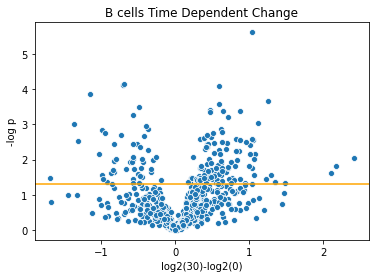

In [12]:
#graph volcano
tstats['-log p'] = -log10(tstats['pvalue'])

figure = sns.scatterplot(x=fc_comp, y='-log p',data=tstats)
figure.set_title("B cells Time Dependent Change")
#plt.axvline(1, color ='orange')
#plt.axvline(-1, color ='orange')
plt.axhline(-log10(.05), color ='orange')
plt.show()

Next we will identify the altered proteins.

In [13]:
altered = prot.is_altered(tstats, pvalue=.05, change_factor=False,
                          change_col=fc_comp, cell_types=cell_types)

In [14]:
tstats.loc[altered.index]

,statistic,pvalue,log2(30)-log2(0),-log p
Protein ID,,,,
O00151,6.156584,0.000272,0.592112,3.565388
O00483,2.821230,0.022451,0.463044,1.648758
O14745,3.443456,0.008779,2.421507,2.056555
O14773,5.752113,0.000428,0.643337,3.368598
O14979,-4.488614,0.002032,-0.741820,2.691975
...,...,...,...,...
Q96C86,2.575954,0.032822,0.393685,1.483832
Q99832,3.066962,0.015419,0.353774,1.811949
Q9UII2,-6.801759,0.000138,-1.155283,3.861457


These are significantly altered (p<0.05) without restricting by the magnitude of change:

In [15]:
altered.value_counts()

B_cells_072920    118
B_cells_062920     50
dtype: int64

In [16]:
print("Here are counts for other p and change cutoffs:")
print("P<0.05, >150% of the other type")
print(prot.is_altered(tstats, pvalue=.05,change_factor=1.5,change_col=fc_comp, cell_types=cell_types).value_counts()) #50% increase from either
print("\nP<0.05, >200% of the other type")
print(prot.is_altered(tstats, pvalue=.05,change_factor=2,change_col=fc_comp, cell_types=cell_types).value_counts()) #Double
print("\nP<0.05, >500% of the other type")
print(prot.is_altered(tstats, pvalue=.05,change_factor=5,change_col=fc_comp, cell_types=cell_types).value_counts()) #5 times larger

print("\nP<0.01, >150% of the other type")
print(prot.is_altered(tstats, pvalue=.01,change_factor=1.5,change_col=fc_comp, cell_types=cell_types).value_counts()) #50% increase from either
print("\nP<0.01, >200% of the other type")
print(prot.is_altered(tstats, pvalue=.01,change_factor=2,change_col=fc_comp, cell_types=cell_types).value_counts()) #Double
print("\nP<0.01, >500% of the other type")
print(prot.is_altered(tstats, pvalue=.01,change_factor=5,change_col=fc_comp, cell_types=cell_types).value_counts()) #5 times larger

Here are counts for other p and change cutoffs:
P<0.05, >150% of the other type
B_cells_072920    59
B_cells_062920    23
dtype: int64

P<0.05, >200% of the other type
B_cells_072920    20
B_cells_062920     5
dtype: int64

P<0.05, >500% of the other type
B_cells_072920    1
dtype: int64

P<0.01, >150% of the other type
B_cells_072920    27
B_cells_062920    11
dtype: int64

P<0.01, >200% of the other type
B_cells_072920    10
B_cells_062920     4
dtype: int64

P<0.01, >500% of the other type
B_cells_072920    1
dtype: int64


### Differentially expressed proteins

Text(0.5, 1.0, 'Day 0 vs Day 30 Subject 1')

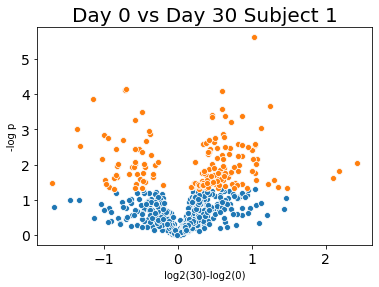

In [17]:
figure = sns.scatterplot(x=fc_comp,y='-log p',data=tstats)
figure2 = sns.scatterplot(x=fc_comp,y='-log p',
                          data=tstats.loc[altered.index])
plt.rc('axes',labelsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Day 0 vs Day 30 Subject 1", fontsize=20)

#plt.savefig("testing/data/0_v_30_1.png", bbox_inches='tight', dpi=300)

This shows the differentially expressed proteins. Recall that this dataset is restricted to those expressed in at least three of each cell type.

The next step is to identify those proteins by name. Here we get the protein names from the fasta file, which remain the same regardless of which software the data was quantified using.


*Note that this function doesn't really have a place in the new set up yet.*

In [18]:
def load_fasta(file="longitudinalCLL/data/uniprot-filtered-proteome_3AUP000005640_reviewed_human.fasta"):
    
    #file is formated:
    #>sp|Q96IY4|CBPB2_HUMAN Carboxypeptidase B2 OS=Homo sapiens OX=9606 GN=CPB2 PE=1 SV=2
    #MKLCS...
    headings = {}
    with open(file) as f:
        for line in f:
            if line.startswith('>'):#header line
                ID = line.split('|')[1]
                name=line.split('|')[2].split('=')[0].strip('OS')
                headings[ID]=name
    headings = pd.Series(list(headings.values()), index=headings.keys())
    
    return headings

In [19]:
protein_names = load_fasta()

In [20]:
protein_names_by_group={}
for ID in prot.data_raw.index:
    if ';' in ID:
        ids = ID.split(';')
        names=''
        for i in ids:
            if i in protein_names.index:
                names=names + protein_names[i] + ';'
        names = names[:-1]
        protein_names_by_group[ID] = names
    else:
        if ID in protein_names.index:
            protein_names_by_group[ID]=protein_names[ID]
protein_names_by_group = pd.Series(list(protein_names_by_group.values()), index=protein_names_by_group.keys())

Here we add the names to the <code>tstats</code> dataframe, which contains the fold changes for each protein. Then we can list the proteins that are altered. Optionally, use <code> head()</code> to display the first few or <code>to_csv</code> to write out to a file. We now split up the proteins heightened in June from those heightened in July.

In [21]:
tstats['Name']=protein_names_by_group
tstats['GeneID'] = tstats.Name.apply(lambda n: str(n).split('_HUMAN')[0])

altered_proteins = tstats.loc[altered.index].sort_values(fc_comp,
                        ascending=False)[['Name','GeneID',fc_comp,'pvalue']]
higher_in_group1 = altered_proteins.loc[altered_proteins[fc_comp] >0]
higher_in_group2 = altered_proteins.loc[altered_proteins[fc_comp] <0]

#To write out to a file, use:
#altered_proteins.to_csv('data/filename.tsv', sep='\t')

Next we do the same for those only identified in one cell type.

In [22]:
data_in_one_type['Name'] = protein_names_by_group
data_in_one_type['GeneID']=data_in_one_type.Name.apply(lambda n: str(n).split('_HUMAN')[0])

group1_only_geneset = data_in_one_type[(data_in_one_type.Type==cell_types[0])]
group2_only_geneset= data_in_one_type[(data_in_one_type.Type==cell_types[1])]

### Proteins Higher in July:

In [23]:
higher_in_group1

,Name,GeneID,log2(30)-log2(0),pvalue
Protein ID,,,,
O14745,NHRF1_HUMAN Na(+)/H(+) exchange regulatory cof...,NHRF1,2.421507,0.008779
P02763,A1AG1_HUMAN Alpha-1-acid glycoprotein 1,A1AG1,2.179159,0.015043
O75306,NDUS2_HUMAN NADH dehydrogenase [ubiquinone] ir...,NDUS2,2.102583,0.024425
P14854,CX6B1_HUMAN Cytochrome c oxidase subunit 6B1,CX6B1,1.482313,0.046868
P69892,HBG2_HUMAN Hemoglobin subunit gamma-2,HBG2,1.351113,0.042037
...,...,...,...,...
P07741,APT_HUMAN Adenine phosphoribosyltransferase,APT,0.231686,0.032584
Q14847,LASP1_HUMAN LIM and SH3 domain protein 1,LASP1,0.216764,0.034158
P13639,EF2_HUMAN Elongation factor 2,EF2,0.194526,0.040831


In [24]:
#sanity check with a couple proteins
#prot.data_frame.loc['P02775']

### Proteins Only in July:

In [25]:
group1_only_geneset[['Name', 'GeneID']]

,Name,GeneID
Protein ID,,
O00161,NP23_HUMAN Synaptosomal-associated protein 23,NP23
O00244,ATOX1_HUMAN Copper transport protein ATOX1,ATOX1
O00442,RTCA_HUMAN RNA 3'-terminal phosphate cyclase,RTCA
O43681,ASNA_HUMAN ATPase ASNA1,ASNA
O60610,DIAP1_HUMAN Protein diaphanous homolog 1,DIAP1
...,...,...
P28068,DMB_HUMAN HLA class II histocompatibility anti...,DMB
P35030,TRY3_HUMAN Trypsin-3,TRY3
P37235,HPCL1_HUMAN Hippocalcin-like protein 1,HPCL1


### Proteins higher or only in July by GeneID
<code>group1_set</code> is defined here as both the above lists of names, those higher or only in group 1 cells.
Note that this might not be the most interesting set of proteins, ie, when comparing data that was not run together those that appear only in one time are much more likely to be run errors.

In [26]:
group1_set = list(higher_in_group1.GeneID)+list(group1_only_geneset.GeneID)

In [27]:
len(group1_set)

196

### Proteins Higher in June:

In [28]:
higher_in_group2.sort_values('pvalue', ascending=True)

,Name,GeneID,log2(30)-log2(0),pvalue
Protein ID,,,,
P40925,"MDHC_HUMAN Malate dehydrogenase, cytoplasmic",MDHC,-0.697160,0.000072
P27695,APEX1_HUMAN DNA-(apurinic or apyrimidinic site...,APEX1,-0.714168,0.000076
Q9UII2,"ATIF1_HUMAN ATPase inhibitor, mitochondrial",ATIF1,-1.155283,0.000138
P09960,LKHA4_HUMAN Leukotriene A-4 hydrolase,LKHA4,-0.486866,0.000316
Q9UI08,EVL_HUMAN Ena/VASP-like protein,EVL,-0.573145,0.000534
P56279,TCL1A_HUMAN T-cell leukemia/lymphoma protein 1A,TCL1A,-1.367644,0.000978
P22626,ROA2_HUMAN Heterogeneous nuclear ribonucleopro...,ROA2,-0.391689,0.001100
Q5SSJ5,HP1B3_HUMAN Heterochromatin protein 1-binding ...,HP1B3,-0.373794,0.001354
P61956,UMO2_HUMAN Small ubiquitin-related modifier 2,UMO2,-0.998122,0.001437


### Proteins Only in June:

In [29]:
group2_only_geneset[['Name', 'GeneID']]

,Name,GeneID
Protein ID,,
O95969,G1D2_HUMAN Secretoglobin family 1D member 2,G1D2
P01833,PIGR_HUMAN Polymeric immunoglobulin receptor,PIGR
P02814,MR3B_HUMAN Submaxillary gland androgen-regulat...,MR3B
P28799,GRN_HUMAN Progranulin,GRN
P47929,LEG7_HUMAN Galectin-7,LEG7
Q6VY07,PACS1_HUMAN Phosphofurin acidic cluster sortin...,PACS1
Q8TAX7,MUC7_HUMAN Mucin-7,MUC7
Q9H1E5,TMX4_HUMAN Thioredoxin-related transmembrane p...,TMX4
Q9UGM3,DMBT1_HUMAN Deleted in malignant brain tumors ...,DMBT1


### Proteins higher or only in June by GeneID
<code>group2_set</code> is defined here as both the above lists of names, those higher or only in June.

In [30]:
group2_set = list(higher_in_group2.GeneID)+list(group2_only_geneset.GeneID)

In [31]:
len(group2_set)

62

In [32]:
#Check to see that June and July differential sets we compiled are distinct lists
#venn2(subsets = (set(group1_set), set(group2_set)), set_labels = ('July', 'June'))
#plt.savefig('data/diff_overlap_2.png')
#plt.show()

### KEGG pathway enrichment
Here I am doing a functional pathway enrichment. I use GProfiler to run a KEGG analysis on the differential proteins.
<code>group1_set</code> is proteins differentially expressed in July
<code>group2_set</code> is proteins differentially expressed in June

In [33]:
gp = GProfiler(return_dataframe = True)

In [34]:
group1 = gp.profile(organism='hsapiens', query=list(group1_set))
group1[group1["source"] == "KEGG"]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
43,KEGG,KEGG:05131,Shigellosis,0.005086,True,Shigellosis,246,46,8,8000,0.173913,0.03252,query_1,[KEGG:00000]
52,KEGG,KEGG:04510,Focal adhesion,0.009669,True,Focal adhesion,200,46,7,8000,0.152174,0.03500,query_1,[KEGG:00000]


In [35]:
group2 = gp.profile(organism='hsapiens', query=list(group2_set))
group2[group2["source"] == "KEGG"]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents


## Suplementary Table: Distinguished Proteins
Here we combine the data from the four categories in one dataframe and output it to a tab-separated file.

First, we get the names of the distinguished proteins.

In [36]:
distinguished_proteins = pd.concat([higher_in_group1, higher_in_group2])

In [37]:
distinguished_proteins

,Name,GeneID,log2(30)-log2(0),pvalue
Protein ID,,,,
O14745,NHRF1_HUMAN Na(+)/H(+) exchange regulatory cof...,NHRF1,2.421507,0.008779
P02763,A1AG1_HUMAN Alpha-1-acid glycoprotein 1,A1AG1,2.179159,0.015043
O75306,NDUS2_HUMAN NADH dehydrogenase [ubiquinone] ir...,NDUS2,2.102583,0.024425
P14854,CX6B1_HUMAN Cytochrome c oxidase subunit 6B1,CX6B1,1.482313,0.046868
P69892,HBG2_HUMAN Hemoglobin subunit gamma-2,HBG2,1.351113,0.042037
...,...,...,...,...
P50452,PB8_HUMAN Serpin B8,PB8,-1.031299,0.007051
Q9UII2,"ATIF1_HUMAN ATPase inhibitor, mitochondrial",ATIF1,-1.155283,0.000138
P02545,LMNA_HUMAN Prelamin-A/C,LMNA,-1.323313,0.003027


Next, we get the intensity data for these proteins.

In [38]:
altered_data = prot.data_frame.loc[distinguished_proteins.index]

Next, we average by cell type, creating new columns in our <code>distinguished_proteins</code> dataframe.

In [39]:
samples=np.array(prot.data_raw.columns.values)

def mean_noNan(ser):
    ser = ser.dropna()
    if len(ser)==0:
        return np.nan
    return mean(ser)

for cell_type in cell_types:
    cells_of_type = list(s for i,s in enumerate(samples) if cell_type in s)
    type_data = altered_data[cells_of_type]
    means = type_data.apply(mean_noNan, axis=1)
    
    distinguished_proteins[("Mean {0}".format(cell_type))] = means

Here we check the column order and rearrange it as we like.

In [40]:
distinguished_proteins.columns

Index(['Name', 'GeneID', 'log2(30)-log2(0)', 'pvalue', 'Mean B_cells_072920',
       'Mean B_cells_062920'],
      dtype='object')

In [41]:
distinguished_proteins = distinguished_proteins[["GeneID", "Mean B_cells_062920", "Mean B_cells_072920", "log2(30)-log2(0)", "pvalue"]]

Here we sort the proteins. This will sort them such that high abundance in June come first, down it low abundance in June, and finally sorting the July only proteins from low to high.

In [42]:
distinguished_proteins.sort_values(["Mean B_cells_062920", "Mean B_cells_072920"], ascending=[False, False], inplace=True)

<ipython-input-42-850e92c8ccdf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distinguished_proteins.sort_values(["Mean B_cells_062920", "Mean B_cells_072920"], ascending=[False, False], inplace=True)


Finally, we have the finished dataframe.

In [43]:
distinguished_proteins

,GeneID,Mean B_cells_062920,Mean B_cells_072920,log2(30)-log2(0),pvalue
Protein ID,,,,,
P69905,HBA,9.715518,10.788147,1.072629,0.006810
P04908,H2A1B,7.185756,7.643079,0.457323,0.009530
P0C0S8,H2A1,7.067460,7.676902,0.609442,0.006864
Q16777,H2A2C,7.063780,7.700652,0.636872,0.003120
P69891,HBG1,6.944228,8.295200,1.350972,0.042088
...,...,...,...,...,...
O95861,BPNT1,-1.735993,-0.966213,0.769780,0.032936
P55036,PSMD4,-2.080931,-1.036175,1.044756,0.002686
P46459,NSF,-2.140154,-1.407816,0.732338,0.036025


The last step is saving this dataframe to a file.

In [44]:
#distinguished_proteins.to_csv('data/distinguished_proteins_Sub1B_Day0_vs30_FP_noMBR.tsv', sep='\t')